# **Imports**

In [2]:
import warnings; warnings.filterwarnings('ignore') # suppression des 'warnings' de l'interpréteur
import struct
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2 as cv
from scipy.signal import convolve2d
from tqdm import tqdm
import IPython.display as dp
from skimage.transform import resize
from sklearn.decomposition import PCA
from numpy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift

# **Fonctions**

In [4]:
def gradient(u):
    m, n = u.shape 
    grad_u = np.zeros((2, m, n))
    grad_u[0, :-1, :] = u[1:] - u[:-1] 
    grad_u[1, :, :-1] = u[:, 1:] - u[:, :-1] 
    return grad_u

In [5]:
def div(p):
    m, n = p.shape[1:] 
    div_1 = np.zeros((m, n))
    div_1[:-1, :] = p[0, :-1, :] 
    div_1[1:, :] -= p[0, :-1, :]
    div_2 = np.zeros((m, n)) 
    div_2[:, :-1] = p[1, :, :-1]  
    div_2[:, 1:] -= p[1, :, :-1] 
    return div_1 + div_2

In [6]:
def laplacian(u):
    return div(gradient(u))

In [7]:
def scalar_product(u, v):
    return np.sum(u * v, axis=0)

def norm(u):
    return np.sqrt(scalar_product(u, u))

In [8]:
def MSE(u_truth, u_estim):
    m, n = u_truth.shape
    return np.sum((u_truth - u_estim)**2) / (m * n)

def PSNR(u_truth, u_estim):
    mse = MSE(u_truth, u_estim)
    return 20 * np.log10(255) - 10 * np.log10(mse)

In [9]:
def convolve(f, G):
    return convolve2d(f, G, mode='same', boundary='symm')

# **Chargement des données**

In [11]:
def loaddat(filename):

    f = open(filename, "rb")
    content = f.read()
    f.close()

    seed = 0

    # Extract the header size
    header_size = struct.unpack("i", content[seed:seed+4])
    header_size = int(header_size[0])
    seed = seed + 4

    # Extract the header data
    header = []
    for i in range(0, header_size): 
        tmp = struct.unpack("i", content[seed:seed+4])
        tmp = int(tmp[0])
        header.append(tmp)
        seed = seed + 4
    
    # Store image resolution parameters
    dimx = header[0]
    dimy = header[1]
    dimz = 1
    no_dyn = 1
    if header_size == 3:
      dimz   = 1
      no_dyn = header[2]
    if header_size == 4:
      dimz   = header[2]
      no_dyn = header[3]

    size = dimx * dimy * dimz * no_dyn
    shape = [dimx, dimy, dimz, no_dyn]

    # Extract data from file
    arr = np.zeros(size, dtype=np.float64, order='F')
    for i in range(0, size): 
        tmp = struct.unpack("f", content[seed:seed+4])
        arr[i] = float(tmp[0])
        seed = seed + 4
    
    arr = np.reshape(arr, shape, order='F')
    return arr

In [12]:
abdomen2D = loaddat("abdomen2D.dat")

**Remarque:** Cela signifie que les données sont en 4 dimensions avec une taille de 128 dans la première dimension, une taille de 128 dans la deuxième dimension, une taille de 1 dans la troisième dimension et une taille de 200 dans la quatrième dimension.

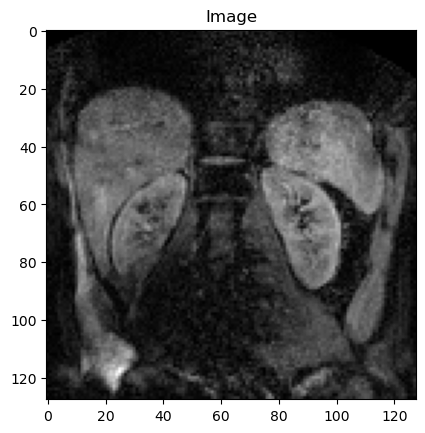

In [14]:
plt.imshow(np.rot90(abdomen2D[:, :,0, 199]), cmap='gray')
plt.title(f'Image')
plt.show()

# **Animation**

In [16]:
image_sequence = []

for i in range(abdomen2D.shape[3]):
    img = np.rot90(abdomen2D[:, :, 0, i])
    image_sequence.append((img * 255).astype(np.uint8))  # Convertir en uint8 pour imageio

# Enregistrer la séquence d'images en tant que fichiers PNG
imageio.mimsave('abdomen2D.gif', image_sequence, duration=0.5)
imageio.mimsave('animation.mp4', image_sequence, fps=10)

In [17]:
dp.Video('animation.mp4', height= 360, html_attributes='autoplay loop')

# **Calcul des gradients**

#### **Normalisation de l'image :**

In [20]:
min_value = np.min(abdomen2D)
max_value = np.max(abdomen2D)
I = (abdomen2D - min_value) / (max_value - min_value)

#### **Calcul du gradient temporel :**

In [22]:
gradT=np.gradient(I ,axis=3)

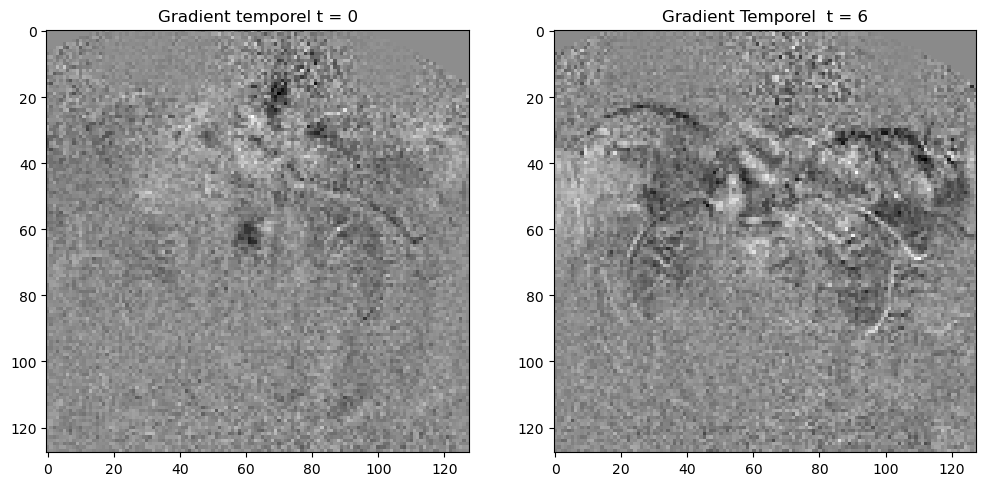

In [23]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(np.rot90(gradT[:, :, 0, 0]), cmap='gray')
plt.title('Gradient temporel t = 0')
plt.subplot(122)
plt.imshow(np.rot90(gradT[:, :, 0, 6]), cmap='gray')
plt.title('Gradient Temporel  t = 6')
plt.show()

#### **Calcul des gradients spatiaux :**

In [25]:
gradS=np.gradient(I,axis=(0,1))
gradSx, gradSy = gradS[0], gradS[1]

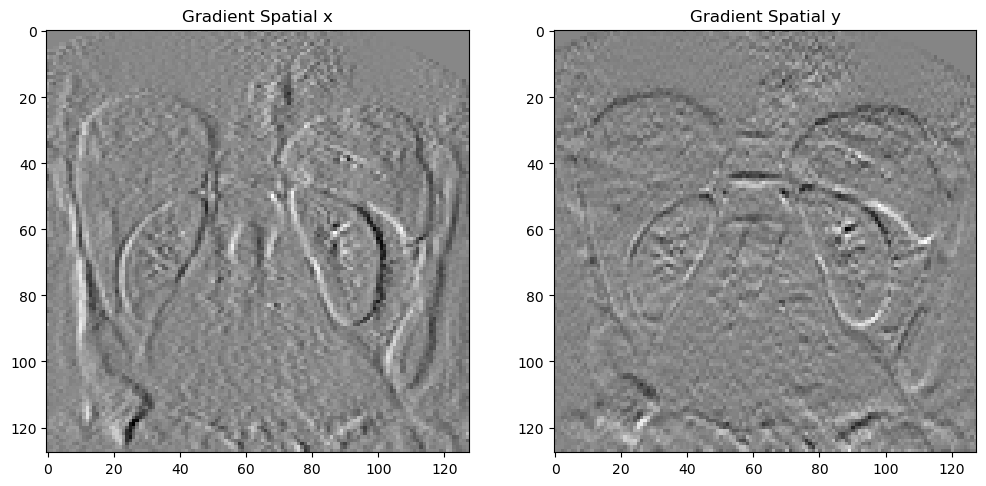

In [26]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(np.rot90(gradSx[:, :, 0, 0]), cmap='gray')
plt.title('Gradient Spatial x')
plt.subplot(122)
plt.imshow(np.rot90(gradSy[:, :, 0, 0]), cmap='gray')
plt.title('Gradient Spatial y')
plt.show()

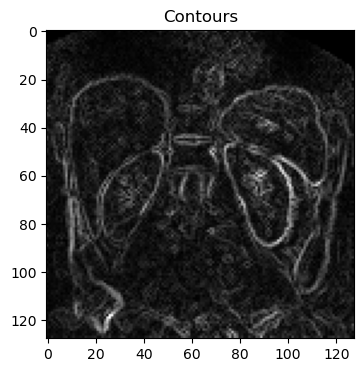

In [27]:
contours = np.sqrt(gradSx**2 + gradSy**2)
plt.figure(figsize=(4,4))
plt.imshow(np.rot90(contours[:, :, 0, 0]), cmap='gray')
plt.title('Contours')
plt.show()

# **Traitement des images en taille réduite**

In [29]:
# Créer une matrice pour stocker les images redimensionnées
abdomen2D_redimensionne = np.zeros((32, 32, 1, abdomen2D.shape[3]), dtype=np.uint8)

# Parcourir les images dans la matrice
for i in range(abdomen2D.shape[3]):
    # Redimensionner l'image
    image_redimensionnee = resize(abdomen2D[:, :, 0, i], (32, 32), anti_aliasing=True)
    
    # Stocker l'image redimensionnée dans la matrice
    abdomen2D_redimensionne[:, :, 0, i] = image_redimensionnee

# Vérifier la forme de la matrice
print(abdomen2D_redimensionne.shape)

(32, 32, 1, 200)


#### **Normalisation de l'image réduite :**

In [31]:
Ired = (abdomen2D_redimensionne - np.min(abdomen2D_redimensionne)) / (np.max(abdomen2D_redimensionne) - np.min(abdomen2D_redimensionne))

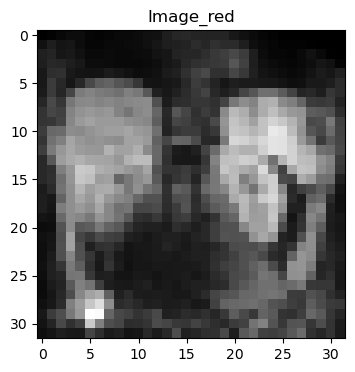

In [32]:
plt.figure(figsize=(4,4))
plt.imshow(np.rot90(Ired[:, :, 0, 199]), cmap='gray')
plt.title('Image_red')
plt.show()

# **Algorithme Horn and  Schunck**

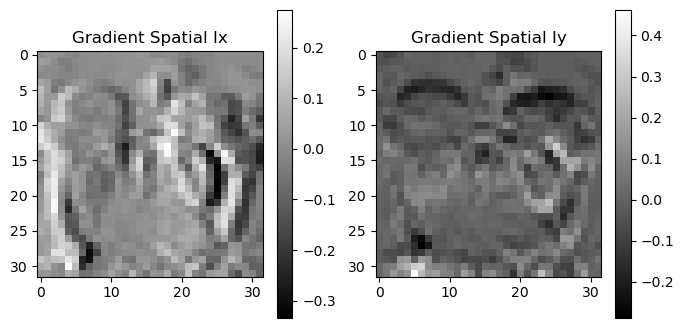

In [34]:
Ix, Iy = np.gradient(Ired[:, :, 0, 0], axis = (0,1))

plt.figure(figsize=(8,4))

plt.subplot(121)
plt.imshow(np.rot90(Ix), cmap='gray')
plt.title('Gradient Spatial Ix')
plt.colorbar()

plt.subplot(122)
plt.imshow(np.rot90(Iy), cmap='gray')
plt.title('Gradient Spatial Iy')
plt.colorbar();

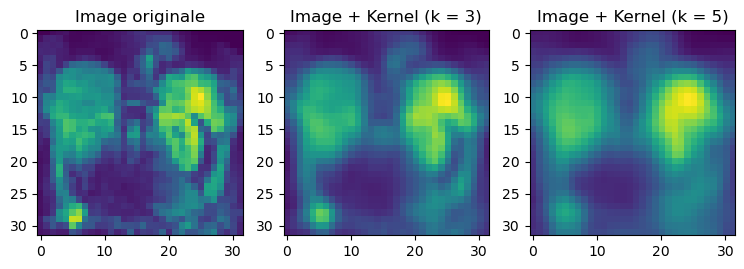

In [35]:
kernel1 = np.ones((3,3))/9

kernel2 = np.ones((5,5))/25

plt.figure(figsize = (9,3))

plt.subplot(131)
plt.imshow(np.rot90(Ired[:, :, 0, 0]))
plt.title("Image originale");

plt.subplot(132)
plt.imshow(np.rot90(convolve(Ired[:, :, 0, 0], kernel1)));
plt.title("Image + Kernel (k = 3)")

plt.subplot(133)
plt.imshow(np.rot90(convolve(Ired[:, :, 0, 0], kernel2)));
plt.title("Image + Kernel (k = 5)");

In [36]:
def horn_schunck(img1 = Ired[:, :, 0, 0], img2 = Ired[:, :, 0, 6], alpha= 0.5 , iterations=100, epsilon=0):
    
    Ix, Iy = np.gradient(img1)
    
    It = img2 - img1
    
    u = np.zeros_like(Ix)
    
    v = np.zeros_like(Iy)
    
    kernel = np.ones((5,5))/25

    energy = []
    
    for i in range(iterations):
        
        u_avg = convolve(u, kernel)
                            
        v_avg = convolve(v, kernel)
        
        u_old = u.copy()
        
        v_old = v.copy()
        
        u = u_avg - Ix * (Ix * u_avg + Iy * v_avg + It) / (alpha + Ix ** 2 + Iy ** 2)
        
        v = v_avg - Iy * (Ix * u_avg + Iy * v_avg + It) / (alpha + Ix ** 2 + Iy ** 2)
        
        ux, uy = np.gradient(u)
        
        vx, vy = np.gradient(v)
        
        E_1 = (Ix * u + Iy * v + It) ** 2
    
        E_2 = (alpha) * (ux ** 2 + uy ** 2 + vx ** 2 + vy ** 2) 
        
        energy.append(np.sum(E_1 + E_2))
        
        diff = np.linalg.norm(E_1 + E_2)
        
        if np.mean(diff) < epsilon: break
        
    return u, v, energy

# **Estimation du mouvemement et paramètres optimaux**

In [38]:
u1, v1 = np.ones((32,32)), np.zeros((32,32))
y, x = np.meshgrid(np.arange(32), np.arange(32))

In [39]:
x1 = np.floor(x - u1).astype(int) % 32
y1 = np.floor(y + v1).astype(int) % 32
x2 = np.floor(x + v1).astype(int) % 32
y2 = np.floor(y - u1).astype(int) % 32

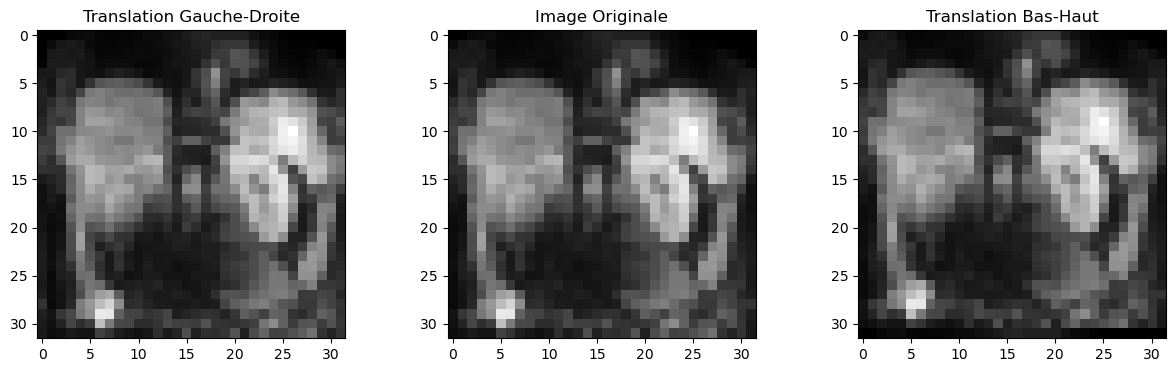

In [40]:
Itest1 = Ired[x1,y1,0,0]

Itest2 = Ired[x2,y2,0,0]

plt.figure(figsize=(15,4))

plt.subplot(131)
plt.imshow(np.rot90(Itest1), cmap ='gray');
plt.title("Translation Gauche-Droite")
           
plt.subplot(132)
plt.imshow(np.rot90(Ired[:,:,0,0]), cmap ='gray');
plt.title("Image Originale")

plt.subplot(133)
plt.imshow(np.rot90(Itest2), cmap ='gray');
plt.title("Translation Bas-Haut");

### **Mean Square Error :**

**Recherche itératif**

In [43]:
alpha_values = np.arange(0.05, 1, 0.05)

itera_values  = np.arange(50, 200, 50)

a_old, b_old, alpha_opt = 1, 1, 1

for alpha in alpha_values:
    for itera in itera_values:
        u_est_1, u_est_2 , energy_1 = horn_schunck(img1 = Ired[:, :, 0, 0], img2 = Itest1, alpha = alpha, iterations = itera, epsilon= 0)
        v_est_2, v_est_2, energy = horn_schunck(img1 = Ired[:, :, 0, 0], img2 = Itest2, alpha = alpha, iterations = itera, epsilon= 0)  
        a1, b1 = MSE(u1, u_est_1), MSE(u1, v_est_2) 

        if (a1 < a_old and b1 < b_old) :
            a_old = a1
            b_old = b1
            alpha_opt = alpha 
            itera_opt = itera

print(f"Marge d'erreur : {(a_old, b_old, alpha_opt, itera_opt)}")

Marge d'erreur : (0.011079804789612962, 0.010988441518320954, 0.15000000000000002, 150)


**Recherche visuelle**

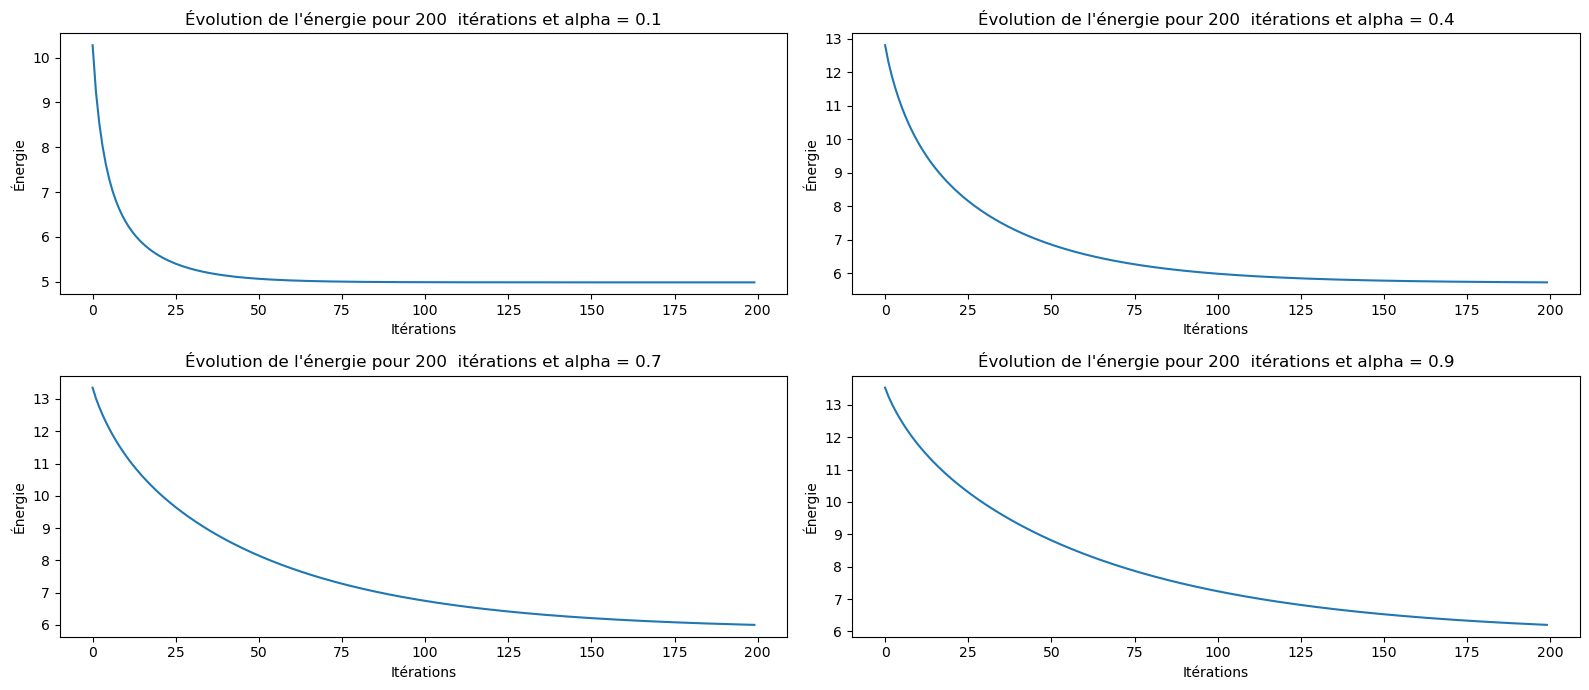

In [45]:
alpha = [0.1, 0.4, 0.7, 0.9]

fig, axes = plt.subplots(2, 2, figsize = (16, 7))

for col, a in enumerate(alpha[:2]):
    u, v, energy = horn_schunck(img1 = Ired[:, :, 0, 0], img2 = Itest1, alpha= a, iterations= 200, epsilon= 0)
    axes[0, col].plot(energy)
    axes[0, col].set_xlabel('Itérations')
    axes[0, col].set_ylabel('Énergie')
    axes[0, col].set_title(f"Évolution de l\'énergie pour 200 "+ f" itérations et alpha = {a}")
    
for col, a in enumerate(alpha[2:]):
    u, v, energy = horn_schunck(img1 = Ired[:, :, 0, 0], img2 = Itest1, alpha= a, iterations= 200, epsilon= 0)
    axes[1, col].plot(energy)
    axes[1, col].set_xlabel('Itérations')
    axes[1, col].set_ylabel('Énergie')
    axes[1, col].set_title(f"Évolution de l\'énergie pour 200 "+ f" itérations et alpha = {a}")
    
plt.tight_layout()
plt.show()

#### **Resultats**

In [47]:
u_est_1, v_est_1, energy = horn_schunck(img1 = Ired[:, :, 0, 0], img2 = Itest1, alpha= 0.15, iterations=150, epsilon= 0)

u_est_2, v_est_2, energy = horn_schunck(img1 = Ired[:, :, 0, 0], img2 = Itest2, alpha= 0.15, iterations=150, epsilon= 0)

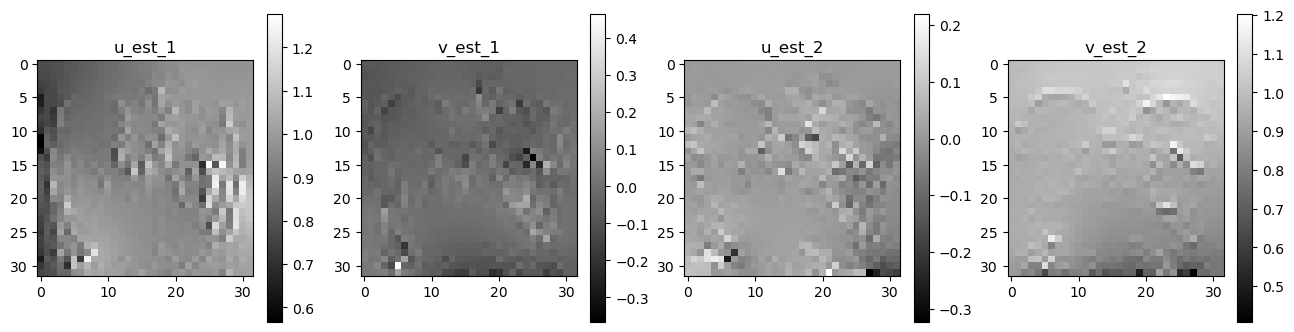

In [48]:
plt.figure(figsize=(16,4))

plt.subplot(141)
plt.imshow(np.rot90(u_est_1), cmap='gray')
plt.title('u_est_1')
plt.colorbar()
plt.subplot(142)
plt.imshow(np.rot90(v_est_1), cmap='gray')
plt.title('v_est_1')
plt.colorbar()
plt.subplot(143)
plt.imshow(np.rot90(u_est_2), cmap='gray')
plt.title('u_est_2')
plt.colorbar()
plt.subplot(144)
plt.imshow(np.rot90(v_est_2), cmap='gray')
plt.title('v_est_2')
plt.colorbar()
plt.show()

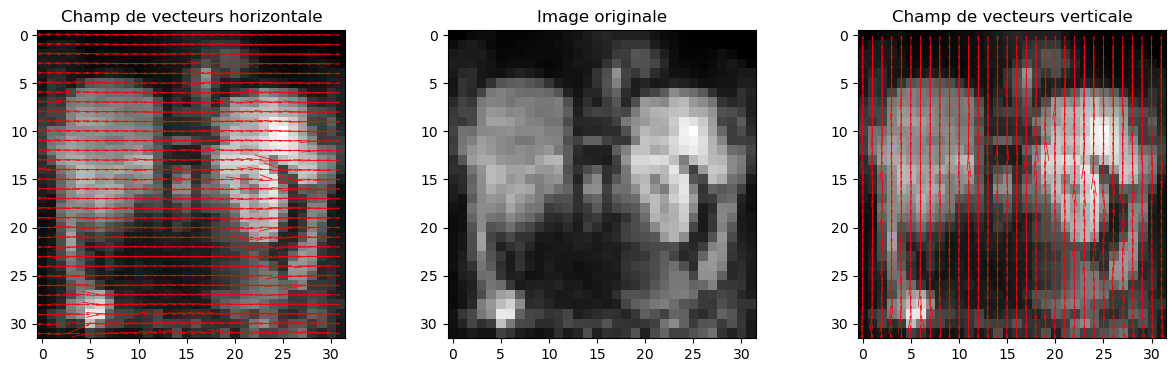

In [49]:
# Création de la figure
plt.figure(figsize=(15,4))

# Création d'une grille pour les vecteurs
x, y = np.meshgrid(np.arange(32), np.arange(32))

# Affichage du champ de vecteurs avec quiver
plt.subplot(131)
plt.quiver(x, y, np.rot90(u_est_1), np.rot90(v_est_1), scale = 16, color='r', angles = 'uv', pivot = 'tip')
plt.imshow(np.rot90(Ired[:, :, 0, 0]), cmap='gray')
plt.title('Champ de vecteurs horizontale')

plt.subplot(132)
plt.imshow(np.rot90(Ired[:, :, 0, 0]), cmap='gray')
plt.title('Image originale')

plt.subplot(133)
plt.quiver(x, y, np.rot90(u_est_2), np.rot90(v_est_2), scale = 16, color='r', angles = 'uv', pivot = 'tip')
plt.imshow(np.rot90(Ired[:, :, 0, 0]), cmap='gray')
plt.title('Champ de vecteurs verticale')

# Affichage
plt.show()

# **Retour Algorithme Horn and Schunck**

In [51]:
u, v, energy = horn_schunck(img1 = Ired[:, :, 0, 0], img2 = Ired[:, :, 0, 6], alpha= 0.15, iterations=150, epsilon= 0)

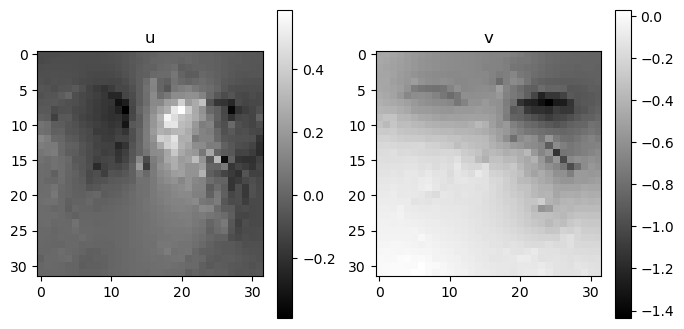

In [52]:
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.imshow(np.rot90(u), cmap='gray')
plt.title('u')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.rot90(v), cmap='gray')
plt.title('v')
plt.colorbar()
plt.show()

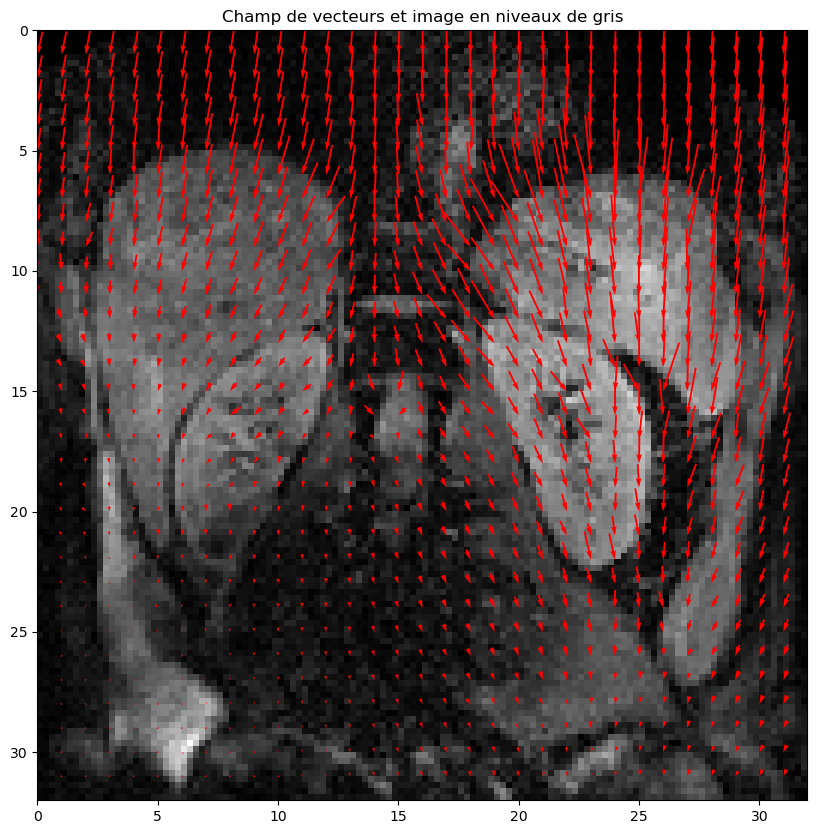

In [53]:
# Création de la figure
plt.figure(figsize=(10, 10))

# Création d'une grille pour les vecteurs
x, y = np.meshgrid(np.arange(32), np.arange(32))

# Affichage du champ de vecteurs avec quiver
plt.quiver(x, y, np.rot90(u), np.rot90(v), color='r',scale = 16, angles = 'uv', pivot = 'tip')

# Affichage de l'image en niveaux de gris
plt.imshow(np.rot90(I[:, :, 0, 0]), cmap='gray',extent=[0,32,32,0])

# Ajout d'un titre
plt.title('Champ de vecteurs et image en niveaux de gris')

# Affichage
plt.show()

In [54]:
Vitesses = []
Energies = []

for i in range(200):
    u1, v1, e1 = horn_schunck(img1=Ired[:, :, 0, 0], img2=Ired[:, :, 0, i], alpha=0.15, iterations=150, epsilon=0)
    Vitesses.append((u1, v1))
    Energies.append(e1)

In [55]:
champs = []

x, y = np.meshgrid(np.arange(32), np.arange(32))

for i in range(200):
    
    plt.figure(figsize=(10, 10))
    u2, v2 = Vitesses[i]
    plt.imshow(np.rot90(I[:, :, 0, i]), cmap='gray',extent=[0,32,32,0])
    plt.quiver(x, y, np.rot90(u2), np.rot90(v2), color='r', angles = 'uv', pivot = 'tip')
    
    
    # Sauvegarder la figure temporairement
    plt.savefig('plot.png')
    
    # Lecture de l'image
    image = plt.imread('plot.png')

    # Redimensionner l'image
    resized_image = resize(image, (1008, 1008), anti_aliasing=True)
    
    # Enregistrer l'image redimensionnée
    plt.imsave('plot_resized.png', resized_image)
    
    # Lire l'image redimensionnée
    quiver = plt.imread('plot_resized.png')
    champs.append((quiver * 255).astype(np.uint8))
    
    plt.close()

In [56]:
# Enregistrer la séquence d'images en tant que fichiers PNG
imageio.mimsave('champs.mp4', champs, fps=7)

dp.Video('champs.mp4', height= 640, html_attributes='autoplay loop')

# **Traitement des images en taille normale**

In [58]:
uhd, vhd, ehd = horn_schunck(img1=I[:, :, 0, 0], img2=I[:, :, 0, 6], alpha=0.15, iterations=150, epsilon=0)

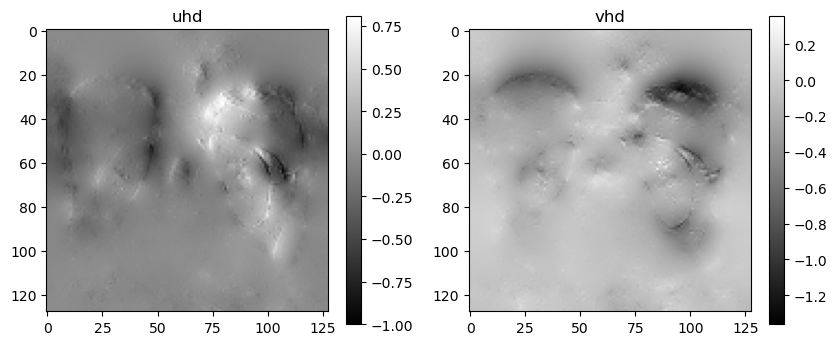

In [59]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.imshow(np.rot90(uhd), cmap='gray')
plt.title('uhd')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.rot90(vhd), cmap='gray')
plt.title('vhd')
plt.colorbar()
plt.show()

# **Analyse en Composante Principale (ACP)**

In [61]:
Vithd = []
Energhd = []

for i in range(200):
    uhd, vhd, ehd = horn_schunck(img1=I[:, :, 0, 0], img2=I[:, :, 0, i], alpha=0.15, iterations=150, epsilon=0)
    Vithd.append((uhd, vhd))
    Energhd.append(ehd)

In [62]:
w = np.array([np.concatenate((u.flatten(), v.flatten())) for u, v in Vithd]) # u et v aplatir puis concatener

Vit_pca = PCA().fit(w)

Vit_comp = Vit_pca.components_ # Composantes principales

Vit_var_rat = (Vit_pca.explained_variance_ratio_)*100 # Inertie en pourcentage

Vit_var_cum = np.cumsum(Vit_var_rat) # Inertie cumulée en pourcentage

Vit_exp_var = Vit_pca.explained_variance_  # Valeurs propres

Vit_val_sing = Vit_pca.singular_values_# Valeurs singulière

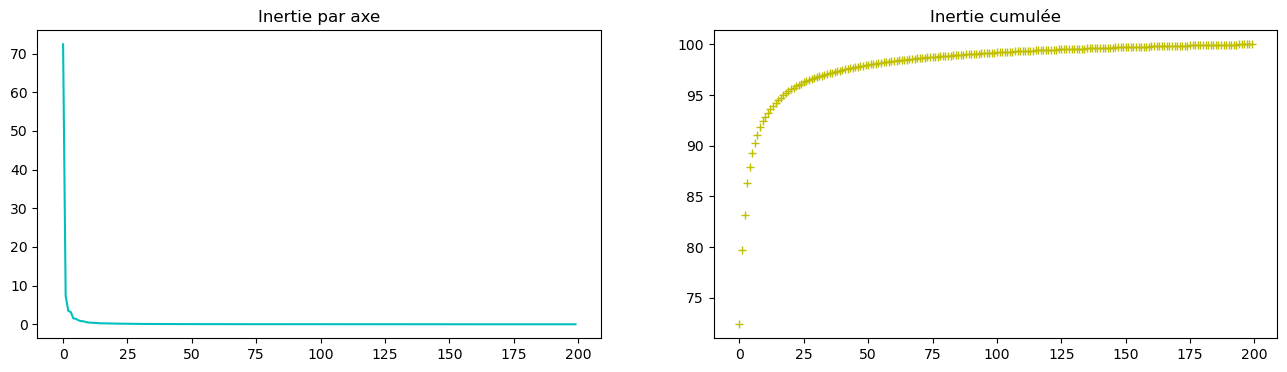

In [63]:
plt.figure(figsize = (16,4))

plt.subplot(121)
plt.plot(Vit_var_rat, 'c')
plt.title('Inertie par axe')

plt.subplot(122)
plt.plot(Vit_var_cum, 'y+')
plt.title('Inertie cumulée')

plt.show();

# **Carte d'amplitude avec les composantes principales en niveau de couleurs**

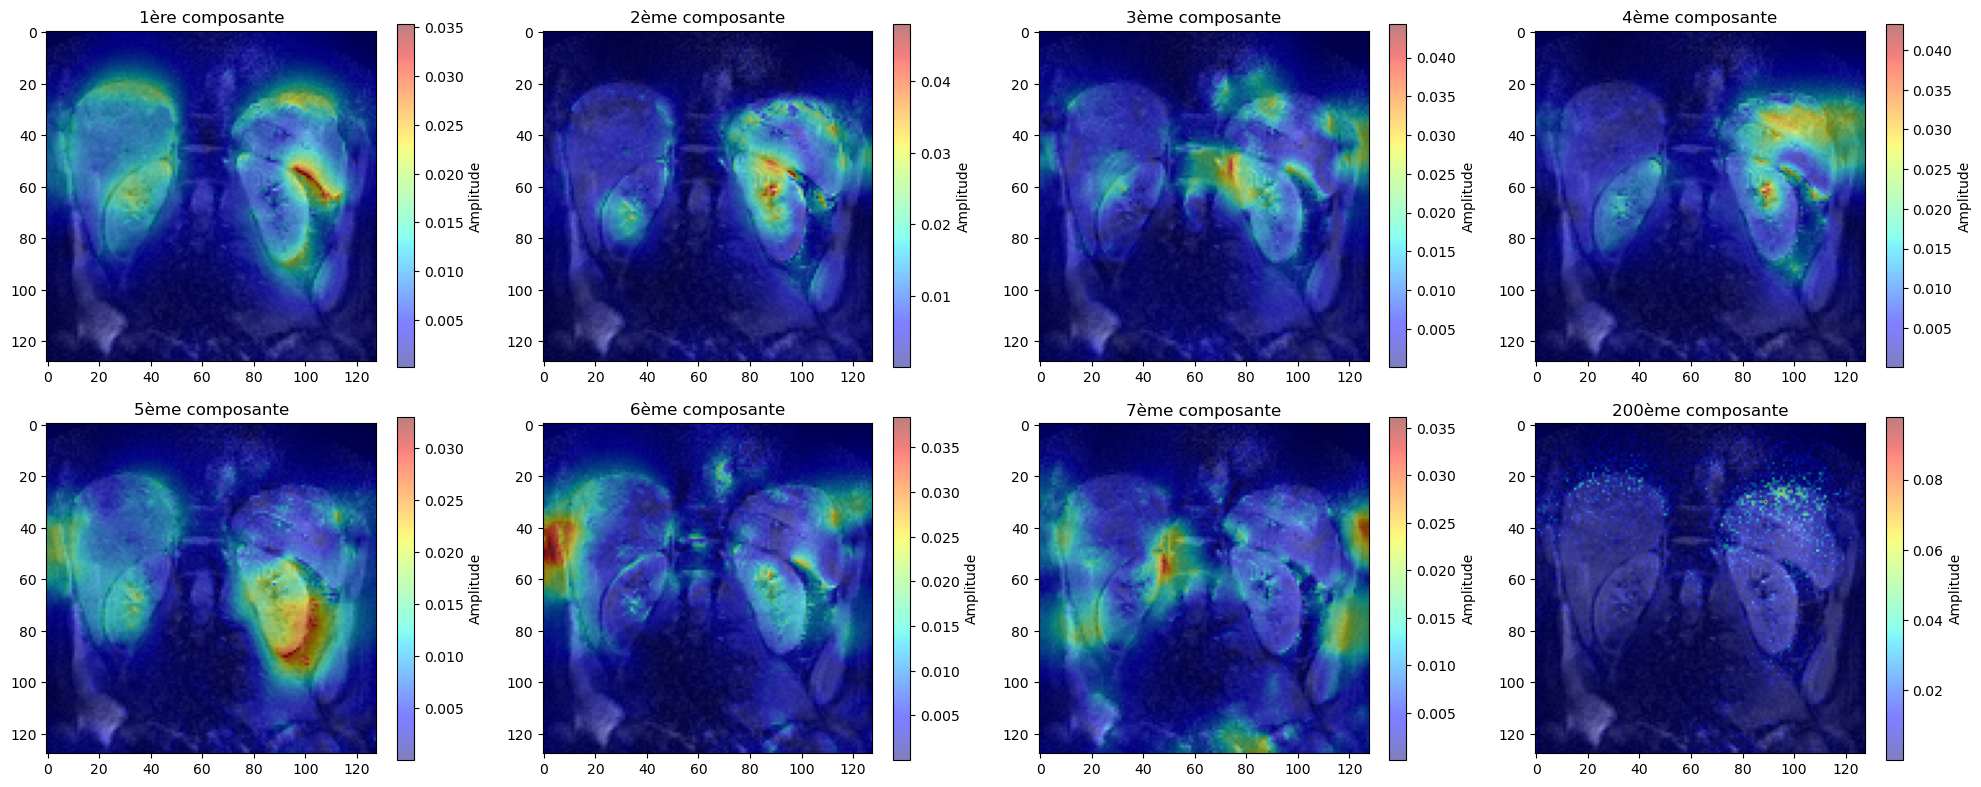

In [65]:
carte_comp = [Vit_comp[i,:].reshape((2,128,128)) for i in range(200)]

plt.figure(figsize = (20, 8))

u1, v1 = carte_comp[0]
amplitude1 = np.sqrt(u1**2 + v1**2)
plt.subplot(241)
plt.imshow(np.rot90(I[:, :, 0, 0]), cmap='gray')
plt.imshow(np.rot90(amplitude1), alpha=0.5, cmap="jet")
plt.title("1ère composante")
plt.colorbar(label='Amplitude');

u2, v2 = carte_comp[1]
amplitude2 = np.sqrt(u2**2 + v2**2)
plt.subplot(242)
plt.imshow(np.rot90(I[:, :, 0, 0]), cmap='gray')
plt.imshow(np.rot90(amplitude2), alpha=0.5, cmap="jet")
plt.title("2ème composante")
plt.colorbar(label='Amplitude');

u3, v3 = carte_comp[2]
amplitude3 = np.sqrt(u3**2 + v3**2)
plt.subplot(243)
plt.imshow(np.rot90(I[:, :, 0, 0]), cmap='gray')
plt.imshow(np.rot90(amplitude3), alpha=0.5, cmap="jet")
plt.title("3ème composante")
plt.colorbar(label='Amplitude');

u4, v4 = carte_comp[3]
amplitude4 = np.sqrt(u4**2 + v4**2)
plt.subplot(244)
plt.imshow(np.rot90(I[:, :, 0, 0]), cmap='gray')
plt.imshow(np.rot90(amplitude4), alpha=0.5, cmap="jet")
plt.title("4ème composante")
plt.colorbar(label='Amplitude');

u5, v5 = carte_comp[4]
amplitude5 = np.sqrt(u5**2 + v5**2)
plt.subplot(245)
plt.imshow(np.rot90(I[:, :, 0, 0]), cmap='gray')
plt.imshow(np.rot90(amplitude5), alpha=0.5, cmap="jet")
plt.title("5ème composante")
plt.colorbar(label='Amplitude');

u6, v6 = carte_comp[5]
amplitude6 = np.sqrt(u6**2 + v6**2)
plt.subplot(246)
plt.imshow(np.rot90(I[:, :, 0, 0]), cmap='gray')
plt.imshow(np.rot90(amplitude6), alpha=0.5, cmap="jet")
plt.title("6ème composante")
plt.colorbar(label='Amplitude');

u7, v7 = carte_comp[6]
amplitude7 = np.sqrt(u7**2 + v7**2)
plt.subplot(247)
plt.imshow(np.rot90(I[:, :, 0, 0]), cmap='gray')
plt.imshow(np.rot90(amplitude7), alpha=0.5, cmap="jet")
plt.title("7ème composante")
plt.colorbar(label='Amplitude');

u200, v200 = carte_comp[199]
amplitude200 = np.sqrt(u200**2 + v200**2)
plt.subplot(248)
plt.imshow(np.rot90(I[:, :, 0, 0]), cmap='gray')
plt.imshow(np.rot90(amplitude200), alpha=0.5, cmap="jet")
plt.title("200ème composante")
plt.colorbar(label='Amplitude');

plt.tight_layout()

# **Descripteurs de mouvements**

In [67]:
mvt = [np.dot(w,p) for p in Vit_comp]
freq=np.arange(1,101)

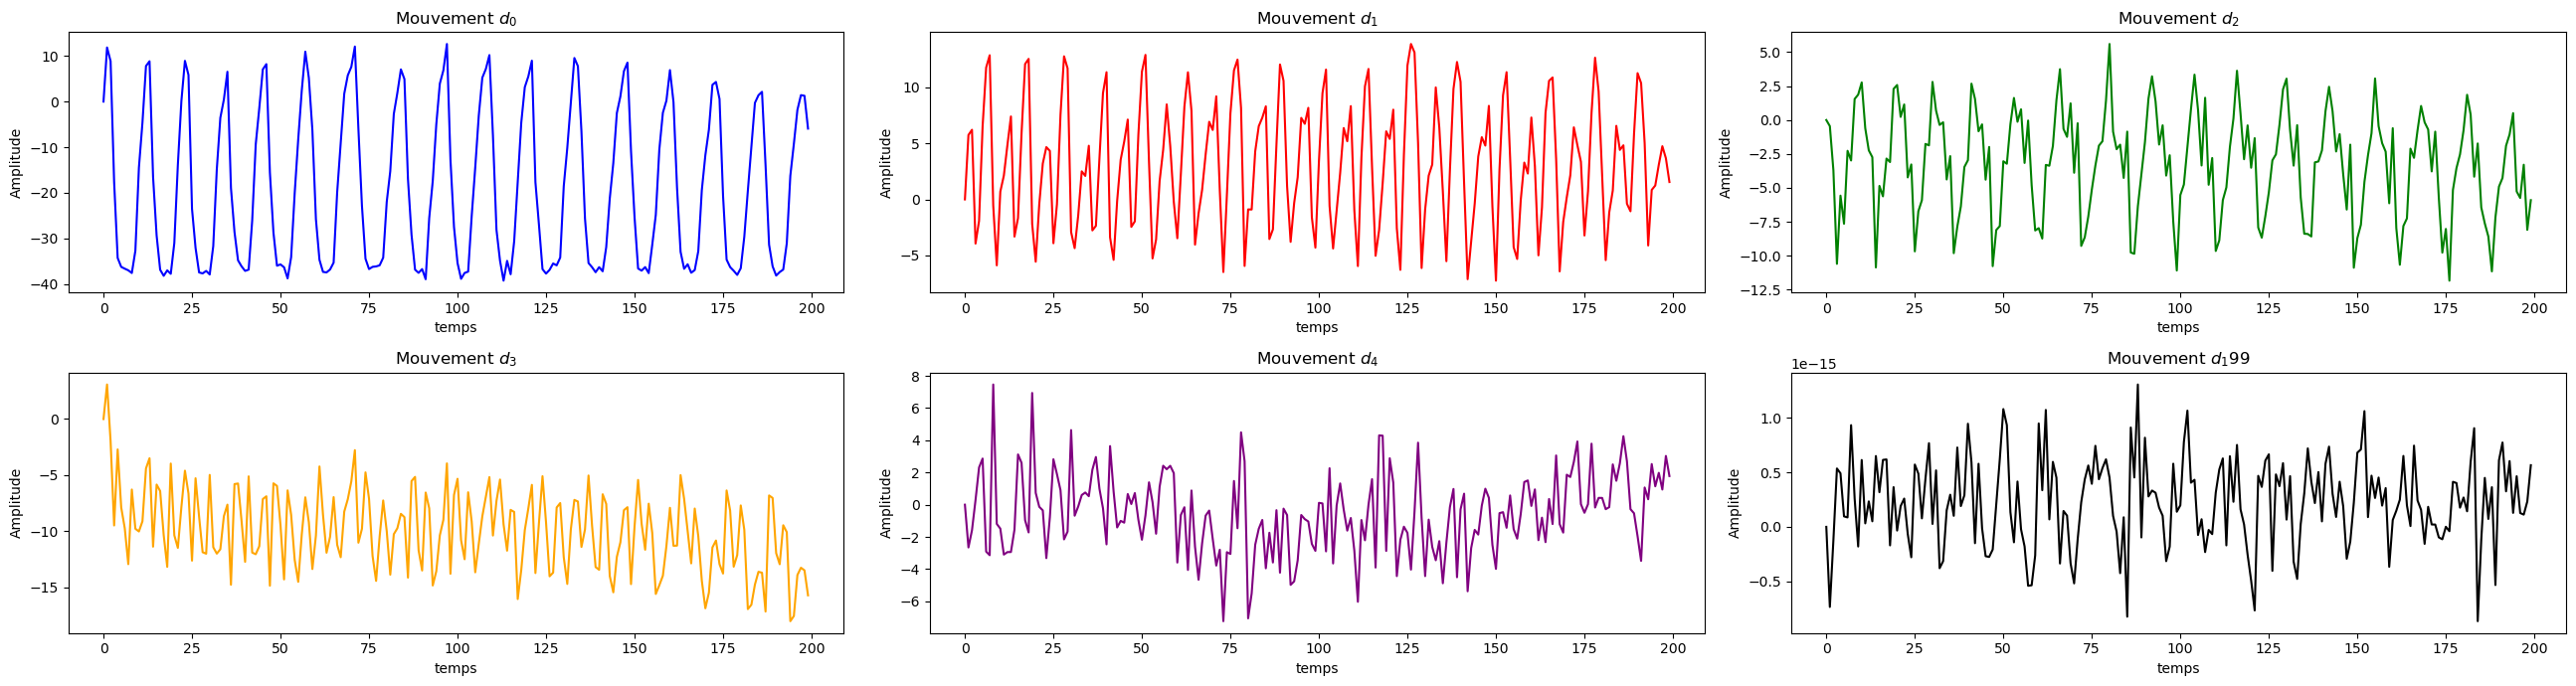

In [68]:
fig, axes = plt.subplots(2, 3, figsize = (26, 7))

colors = ["blue", "red", "green", "orange", "purple", "black" ]

for i, (a, color) in enumerate (zip(mvt[:3], colors[:3])):
    axes[0, i].plot(a, color = color)
    axes[0, i].set_xlabel('temps')
    axes[0, i].set_ylabel('Amplitude')
    axes[0, i].set_title(f"Mouvement $d_{i}$")
    
for j, (a, color) in enumerate (zip(mvt[3:5], colors[3:5])):
    axes[1, j].plot(a, color = color)
    axes[1, j].set_xlabel('temps')
    axes[1, j].set_ylabel('Amplitude')
    axes[1, j].set_title(f"Mouvement $d_{j + 3}$")
    
axes[1, 2].plot(mvt[199], color = "black")
axes[1, 2].set_xlabel('temps')
axes[1, 2].set_ylabel('Amplitude')
axes[1, 2].set_title(f"Mouvement $d_{199}$")

plt.tight_layout()
plt.show()

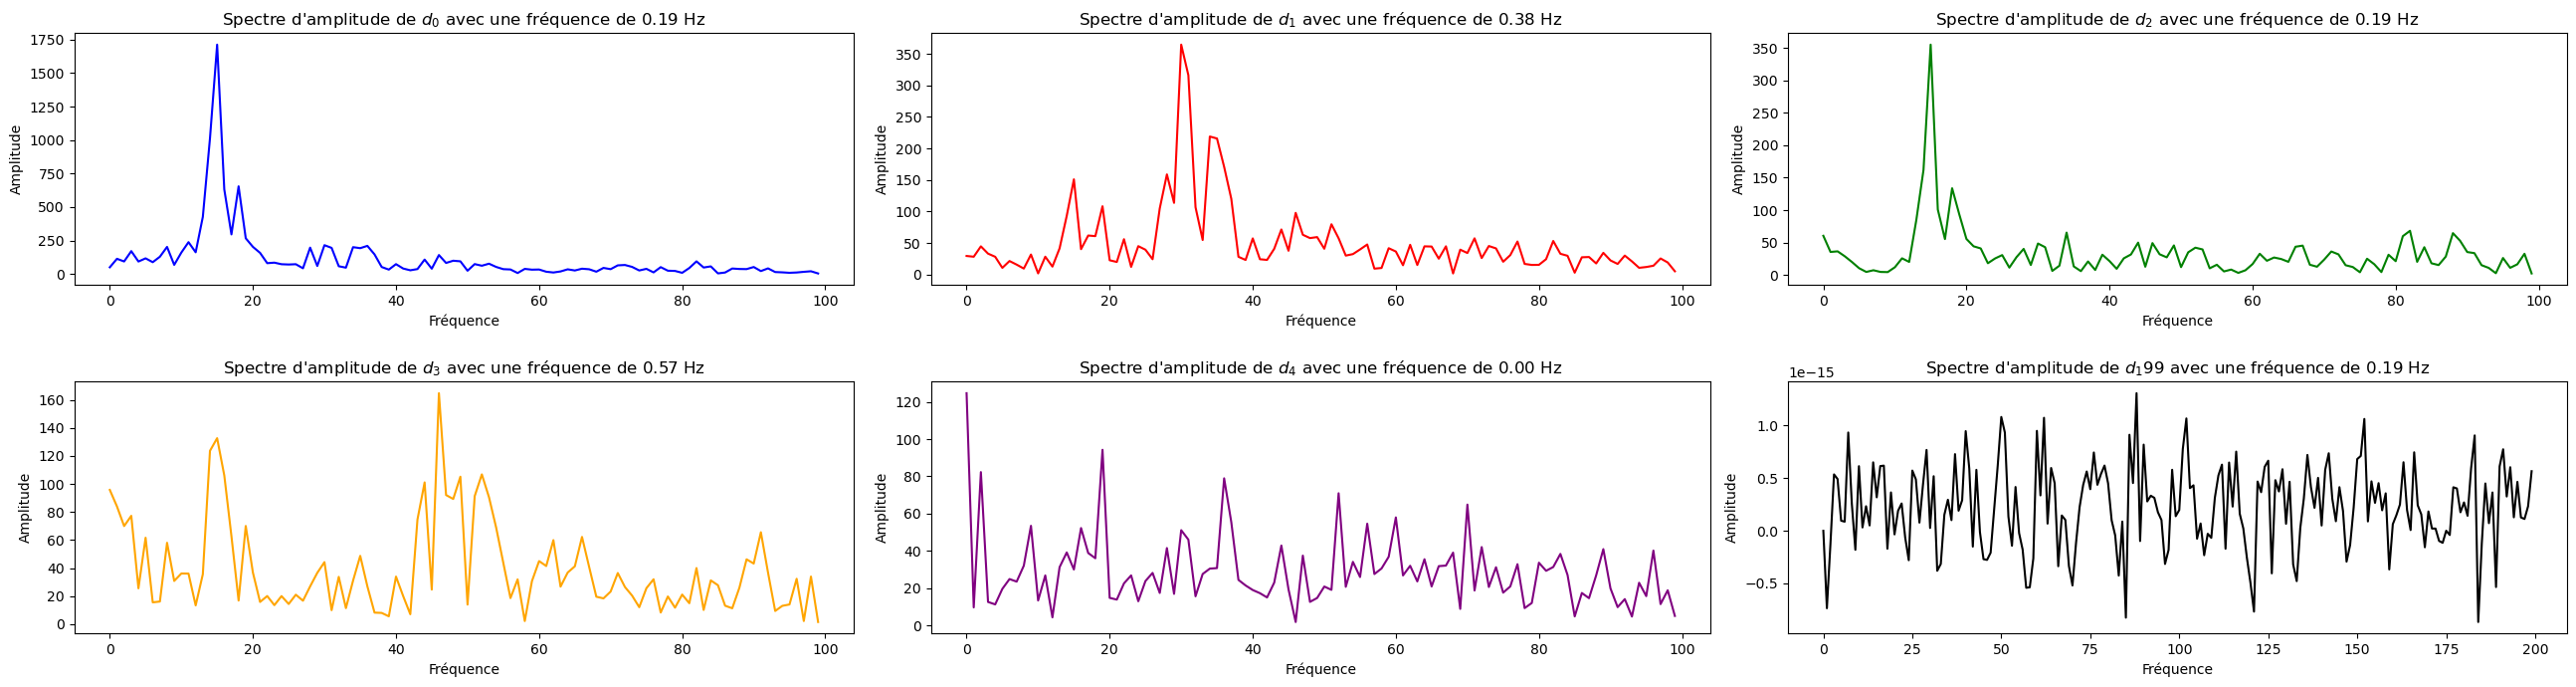

In [69]:
fig, axes = plt.subplots(2, 3, figsize = (26, 7))

colors = ["blue", "red", "green", "orange", "purple", "black" ]

for i, (a, color) in enumerate (zip(mvt[:3], colors[:3])):
    F_D = fft(a)
    Sp_D = np.abs(F_D[freq])
    axes[0, i].plot(Sp_D, color = color)
    axes[0, i].set_xlabel('Fréquence')
    axes[0, i].set_ylabel('Amplitude')
    axes[0, i].set_title(f"Spectre d'amplitude de $d_{i}$ avec une fréquence de {(np.argmax(Sp_D.T)/(0.4 * 200)):.2f} Hz")
    
for j, (a, color) in enumerate (zip(mvt[3:5], colors[3:5])):
    F_D = fft(a)
    Sp_D = np.abs(F_D[freq])
    axes[1, j].plot(Sp_D, color = color)
    axes[1, j].set_xlabel('Fréquence')
    axes[1, j].set_ylabel('Amplitude')
    axes[1, j].set_title(f"Spectre d'amplitude de $d_{j + 3}$ avec une fréquence de {(np.argmax(Sp_D.T)/(0.4 * 200)):.2f} Hz")

F_D = fft(mvt[199])
Sp_D = np.abs(F_D[freq])
axes[1, 2].plot(mvt[199], color = "black")
axes[1, 2].set_xlabel('Fréquence')
axes[1, 2].set_ylabel('Amplitude')
axes[1, 2].set_title(f"Spectre d'amplitude de $d_{ 199 }$ avec une fréquence de {(np.argmax(Sp_D.T)/(0.4 * 200)):.2f} Hz")

plt.tight_layout()
plt.show()